In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from hierarchical_generalization.make_datasets import generate_phase_train_test_data

## Data

In [2]:
train_data, test_data = generate_phase_train_test_data() 

print(train_data.keys(), test_data.keys())
print(train_data['Phase A'][0].shape, train_data['Phase A'][1].shape) # trials x color x shape

dict_keys(['Phase A', 'Phase B', 'Phase C']) dict_keys(['Phase A', 'Phase B', 'Phase C'])
(120, 5, 4) (120, 4)


In [3]:
train, target = train_data['Phase A']
trial = train[105]
trial

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [4]:
def onehot(data):
    """
    input: trials x color x shape
    output: trials x onehotcoding of color and shape
    """
    num_trials = data.shape[0]
    length = data.shape[1] + data.shape[2]
    one_hot = torch.zeros([num_trials, length])
    
    for i in range(num_trials):
        dim0 = data[i].sum(axis=0).argmax()
        dim1 = data[i].sum(axis=1).argmax()
        one_hot[i][dim0] = 1
        one_hot[i][data.shape[1] - 1 + dim1] = 1
        
    return one_hot

In [5]:
onehot(train)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
def phase_data(phase):
    train_data, test_data = generate_phase_train_test_data()
    train, test = train_data[phase]
    train = onehot(train)
    test = torch.from_numpy(test)
    return train, test

train, test = phase_data('Phase A')
print(train.size(), test.size()) # batch x features; batch x actions

torch.Size([120, 9]) torch.Size([120, 4])


In [7]:
train[7:11]

tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.]])

In [8]:
test[7:11]

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)

### Helper functions

#### plot

In [9]:
def plot_loss(phase, all_losses):
    """
    all_losses must be an array
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Trials')
    ax.set_ylabel('Loss')
    ax.set_title(phase)
    for i in range(len(all_losses)):
        if all_losses[i] < 0.1:
            ax.text(i*0.9, all_losses[i]*1.4, s=(i, str(all_losses[i])[:4]))
            break
    ax.plot(all_losses)

In [10]:
def plot_accuracy(phase, all_accus):
    """
    all_losses can be an array or a matrix
    """
    phases = ['Phase A', 'Phase B', 'Phase C']
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Trials')
    ax.set_ylabel('Accuracy')
    ax.set_title(phase)
    ax.set_ylim([0, 1.1])
    ax.set_yticks(np.arange(0,1.1,0.2))
    ax.spines['top'].set_visible(False)  #去掉上边框
    ax.spines['right'].set_visible(False) #去掉右边框
    for j in range(all_accus.shape[-1]):
        all_accu = all_accus[:, j]
        for i in range(len(all_accu)):
            if all_accu[i] > 0.9:
                ax.text(i, all_accu[i], s=i)
                break
        ax.plot(all_accu, label=phases[j])
        ax.legend() #loc='upper right'

#### test overall generalization

In [11]:
def test_all_RLphase(plot=False, ifprint=False):
    phases = ['Phase A', 'Phase B', 'Phase C']
    train_data, test_data = generate_phase_train_test_data()
    all_accu = []
    
    for phase in phases:
        test_input, test_target = test_data[phase]
        test_input = onehot(test_input)
        test_target = torch.from_numpy(test_target)
    
        with torch.no_grad():
            score = 0
            batch_size = test_input.size(0)
            for i in range(batch_size):
                done = False
                while not done:
                    action = agent.choose_action(test_input[i])
                    reward = (action == test_target[i].argmax())
                    done = True
                    score += reward
            all_accu.append(score)
            if ifprint:
                print(f"Accuracy in {phase} is: {score.item()/batch_size:.2%}")

    if plot:
        all_accu = np.array(all_accu) / 120
        f, ax = plt.subplots(figsize=(4, 4))
        ax.bar(phases, all_accu, width=0.5)
        for i in range(3):
            ax.text(i, all_accu[i]*1.05, '%.3f' % all_accu[i], ha='center', va= 'bottom')
    
    return all_accu

#### test C0-C1 vs C2

In [12]:
from hierarchical_generalization.make_datasets import generate_taskset_test_data

# Outputs the taskset test data
ts_test_data = generate_taskset_test_data()
ts_test_data.keys()

dict_keys(['TS 1 Phase A', 'TS 2 Phase A', 'TS 1 Phase B', 'TS 2 Phase B', 'TS Old Phase C', 'TS New Phase C'])

In [13]:
TS_1_PhaseA = ts_test_data['TS 1 Phase A']
TS_2_PhaseA = ts_test_data['TS 2 Phase A']
TS_1_PhaseB = ts_test_data['TS 1 Phase B']
TS_2_PhaseB = ts_test_data['TS 2 Phase B']
TS_Old_PhaseC = ts_test_data['TS Old Phase C']
TS_New_PhaseC = ts_test_data['TS New Phase C']

In [14]:
def phase_test(phase, batch_size=120):
    ts_test_data = generate_taskset_test_data()
    train, target = ts_test_data[phase]
    train = onehot(train)
    target = torch.from_numpy(target)
    return train[:batch_size], target[:batch_size]

TS1_PhaseA_train, TS1_PhaseA_target = phase_test('TS 1 Phase A')
print(TS1_PhaseA_train.size(), TS1_PhaseA_target.size()) # batch x features; batch x actions

TS1_PhaseA_train, TS1_PhaseA_target = phase_test('TS 2 Phase A')
print(TS1_PhaseA_train.size(), TS1_PhaseA_target.size()) # batch x features; batch x actions

torch.Size([4, 9]) torch.Size([4, 4])
torch.Size([2, 9]) torch.Size([2, 4])


In [15]:
def test_RL_C0C1vsC2(phase):
    """
    phase: 'Phase A' or 'Phase B'
    """
    TS1_train, TS1_target = phase_test('TS 1 '+phase)
    TS2_train, TS2_target = phase_test('TS 2 '+phase)

    TS1_accu = []
    TS2_accu = []

    with torch.no_grad():
        for i in range(TS1_target.size(0)):
            score = 0
            done = False
            while not done:
                action = agent.choose_action(TS1_train[i])
                reward = (action == TS1_target[i].argmax())
                done = True
                score += reward
        TS1_accu.append(score)
            
        for i in range(TS2_target.size(0)):
            score = 0
            done = False
            while not done:
                action = agent.choose_action(TS2_train[i])
                reward = (action == TS2_target[i].argmax())
                done = True
                score += reward
        TS2_accu.append(score)
            
    return (np.mean(TS1_accu), np.mean(TS2_accu))

####  test novel context

In [16]:
def test_RL_OldvsNew():
    TS_Old_train, TS_Old_target = phase_test('TS Old Phase C')
    TS_New_train, TS_New_target = phase_test('TS New Phase C')
    Old_accu = []
    New_accu = []

    with torch.no_grad():
        for i in range(TS_Old_target.size(0)):
            score = 0
            done = False
            while not done:
                action = agent.choose_action(TS_Old_train[i])
                reward = (action == TS_Old_target[i].argmax())
                done = True
                score += reward
        Old_accu.append(score)
            
        for i in range(TS_New_target.size(0)):
            score = 0
            done = False
            while not done:
                action = agent.choose_action(TS_New_train[i])
                reward = (action == TS_New_target[i].argmax())
                done = True
                score += reward
        New_accu.append(score)
            
    return (np.mean(Old_accu), np.mean(New_accu))

## Actor Critic

In [17]:
a = torch.distributions.Categorical(torch.tensor([0.1, 0.5, 0.1, 0.4]))
a.sample().item()
a.log_prob(a.sample())

tensor(-1.0116)

### Actor Critic MLP model

In [18]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=128, fc2_dims=128):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)
        return (pi, v)

class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions, 
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = torch.as_tensor(observation, dtype=torch.float32)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=0)
        action_probs = torch.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, done):
        state = torch.as_tensor(state, dtype=torch.float32)
        reward = torch.as_tensor(reward, dtype=torch.float32)

        _, value = self.actor_critic.forward(state)

        delta = reward - value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2
        
        self.actor_critic.optimizer.zero_grad()
        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

### Train on phase A

In [19]:
def plot_accuracy(phase, accuracy):
    """
    all_losses must be an array
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Accuracy')
    ax.set_title(phase)
    for i in range(len(accuracy)):
        if accuracy[i] > 0.9:
            ax.text(i, accuracy[i], s=(i, str(accuracy[i])[:4]))
            break
    ax.plot(accuracy)

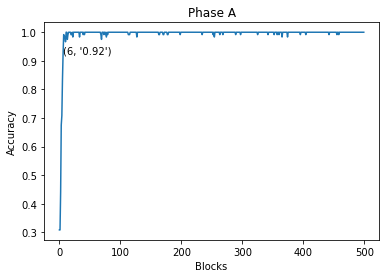

In [20]:
agent = Agent(lr=1e-3, input_dims=9, n_actions=4, fc1_dims=128, fc2_dims=128)

def play_game(phase, n_blocks=500, converge_stop=True):
    scores = []
    for _ in range(n_blocks):
        observation, target = phase_data(phase)
        score = 0
        for i in range(observation.size(0)):
            done = False
            while not done:
                action = agent.choose_action(observation[i])
                reward = (action == target[i].argmax())
                done = True
                score += reward
                agent.learn(observation[i], reward, done)

        scores.append(score)
        if converge_stop and np.sum(scores[-3:]) > 300:
            break
    accuracy = np.array(scores) / observation.size(0)
    return accuracy

accuracyA = play_game('Phase A', converge_stop=False)
plot_accuracy('Phase A', accuracyA)

In [30]:
agent = Agent(lr=1e-3, input_dims=9, n_actions=4, fc1_dims=128, fc2_dims=128)

def play_game(phase, n_blocks=500, converge_stop=True):
    scores = []
    all_accu = []
    T1_all_accu = []
    T2_all_accu = []
    for _ in range(n_blocks):
        observation, target = phase_data(phase)
        score = 0
        for i in range(observation.size(0)):
            done = False
            while not done:
                action = agent.choose_action(observation[i])
                reward = (action == target[i].argmax())
                done = True
                score += reward
                
                accuracy = test_all_RLphase()
                all_accu.append([i.item() for i in accuracy])

                if phase != 'Phase C':
                    TS1_accu, TS2_accu = test_RL_C0C1vsC2(phase)
                    T1_all_accu.append(TS1_accu)
                    T2_all_accu.append(TS2_accu)
                else:
                    Old_accu, New_accu = test_RL_OldvsNew()
                    T1_all_accu.append(Old_accu)
                    T2_all_accu.append(New_accu)   
                agent.learn(observation[i], reward, done)
                

        scores.append(score)
        if converge_stop and np.sum(scores[-3:]) > 300:
            break
    accuracy = np.array(scores) / observation.size(0)
    return accuracy, np.array(all_accu), np.array(T1_all_accu), np.array(T2_all_accu)

In [31]:
accuracyA, all_accuA, T1_all_accuA, T2_all_accuA = play_game('Phase A', converge_stop=True)

KeyboardInterrupt: 

In [ ]:
plot_loss('Phase A', accuracyA)
plot_accuracy('Phase A', all_accuA)

Accuracy in Phase A is: 100.00%
Accuracy in Phase B is: 40.83%
Accuracy in Phase C is: 25.83%


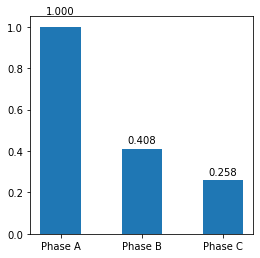

In [24]:
test_all_RLphase(plot=True)

### Transfer phase

Accuracy in Phase A is: 88.33%
Accuracy in Phase B is: 98.33%
Accuracy in Phase C is: 75.83%


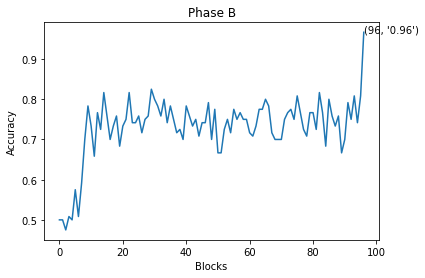

In [25]:
accuracyB = play_game('Phase B')
plot_accuracy('Phase B', accuracyB)
test_all_RLphase()

Accuracy in Phase A is: 89.17%
Accuracy in Phase B is: 99.17%
Accuracy in Phase C is: 100.00%


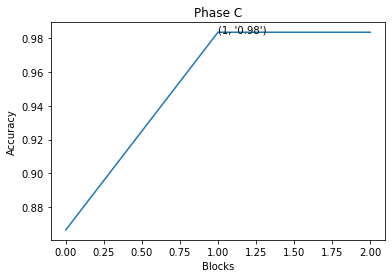

In [26]:
accuracyC = play_game('Phase C')
plot_accuracy('Phase C', accuracyC)
test_all_RLphase()

### Learning Curve

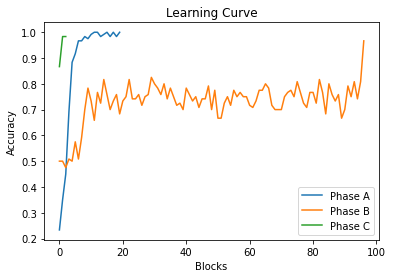

In [27]:
def plot_learningcurve(phases, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Accuracy')
    ax.set_title("Learning Curve")
    for j in range(len(phases)):
        all_loss = all_losses[j]
        for i in range(len(all_loss)):
            if all_loss[i] < 0.1:
                ax.text(i*0.9, all_loss[i]*1.3, s=i)
                break
        ax.plot(all_loss, label=phases[j])
        ax.legend()
        
plot_learningcurve(['Phase A', 'Phase B', 'Phase C'], 
                                   [accuracyA[:20], accuracyB, accuracyC])

## Actor Critic LSTM

### Actor Critic LSTM model

In [28]:
class ActorCriticLSTM(nn.Module):
    def __init__(self, lr, input_size, n_actions, hidden_size, num_layers):
        super(ActorCriticLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.pi = nn.Linear(hidden_size, n_actions)
        self.v = nn.Linear(hidden_size, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return [h0, c0]
    
    def forward(self, x):
        hidden = self.init_hidden(1)
        #steps = x.size(0) # squence length
        out, hidden = self.lstm(x, hidden)
        pi = self.pi(out)
        v = self.v(out)
        return (pi, v)

class AgentLSTM():
    def __init__(self, lr, input_size, n_actions, hidden_size, num_layers, gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.actor_critic_lstm = ActorCriticLSTM(lr, input_size, n_actions, 
                                               hidden_size, num_layers)
        self.log_prob = None

    def choose_action(self, observation):
        state = torch.as_tensor(observation, dtype=torch.float32)
        probabilities, _ = self.actor_critic_lstm.forward(state)
        probabilities = F.softmax(probabilities, dim=2)
        action_probs = torch.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, done):
        state = torch.as_tensor(state, dtype=torch.float32)
        reward = torch.as_tensor(reward, dtype=torch.float)

        _, value = self.actor_critic_lstm.forward(state)

        delta = reward - value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2
        
        self.actor_critic_lstm.optimizer.zero_grad()
        (actor_loss + critic_loss).backward()
        self.actor_critic_lstm.optimizer.step()

### Train on phase A

In [29]:
LSTMagent = AgentLSTM(lr=0.001, input_size=9, n_actions=4, hidden_size=128, num_layers=2)

def play_LSTM_game(phase, n_blocks=100, converge_stop=True):
    scores = []

    for _ in range(n_blocks):
        observation, target = phase_data(phase)
        score = 0
        for i in range(observation.size(0)):
            done = False
            while not done:
                this_obs = observation[i].reshape(1, 1, -1)
                action = LSTMagent.choose_action(this_obs)
                reward = (action == target[i].argmax())
                done = True
                score += reward
                LSTMagent.learn(this_obs, reward, done)

        scores.append(score)
        if converge_stop and np.sum(scores[-3:]) > 300:
            break
    accuracy = np.array(scores) / observation.size(0)
    return accuracy

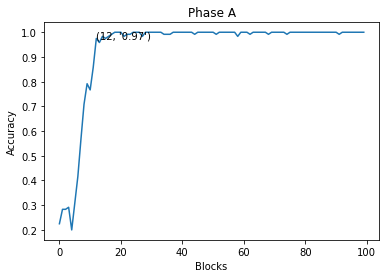

In [30]:
accuracyA = play_LSTM_game('Phase A', converge_stop=False)
plot_accuracy('Phase A', accuracyA)

Accuracy in Phase A is: 100.00%
Accuracy in Phase B is: 23.33%
Accuracy in Phase C is: 20.00%


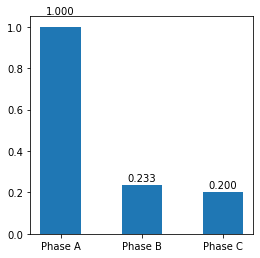

In [31]:
def test_all_RLLSTMphase(plot=False):
    phases = ['Phase A', 'Phase B', 'Phase C']
    train_data, test_data = generate_phase_train_test_data()
    all_accu = []
    
    for phase in phases:
        test_input, test_target = test_data[phase]
        test_input = onehot(test_input)
        test_target = torch.from_numpy(test_target)
    
        with torch.no_grad():
            score = 0
            batch_size = test_input.size(0)
            for i in range(batch_size):
                done = False
                while not done:
                    this_obs = test_input[i].reshape(1, 1, -1)
                    action = LSTMagent.choose_action(this_obs)
                    reward = (action == test_target[i].argmax())
                    done = True
                    score += reward
            all_accu.append(score)
            print(f"Accuracy in {phase} is: {score.item()/batch_size:.2%}")

    if plot:
        all_accu = np.array(all_accu) / 120
        f, ax = plt.subplots(figsize=(4, 4))
        ax.bar(phases, all_accu, width=0.5)
        for i in range(3):
            ax.text(i, all_accu[i]*1.05, '%.3f' % all_accu[i], ha='center', va= 'bottom')
            
test_all_RLLSTMphase(plot=True)

### Transfer phase LSTM

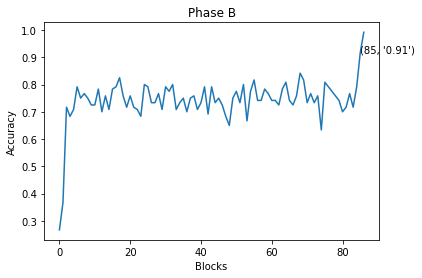

In [32]:
accuracyB = play_LSTM_game('Phase B')
plot_accuracy('Phase B', accuracyB)

Accuracy in Phase A is: 22.50%
Accuracy in Phase B is: 90.83%
Accuracy in Phase C is: 100.00%


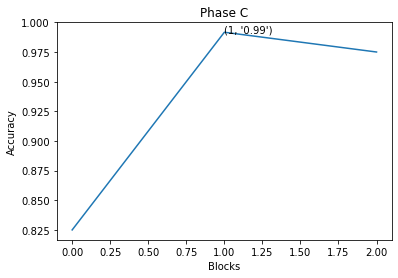

In [33]:
accuracyC = play_LSTM_game('Phase C')
plot_accuracy('Phase C', accuracyC)
test_all_RLLSTMphase()

### Learning Curve

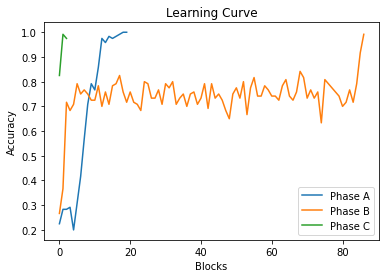

In [34]:
plot_learningcurve(['Phase A', 'Phase B', 'Phase C'], 
                                   [accuracyA[:20], accuracyB, accuracyC])